In [1]:
import pandas as pd
import cv2
import math
import numpy as np
from google.colab.patches import cv2_imshow

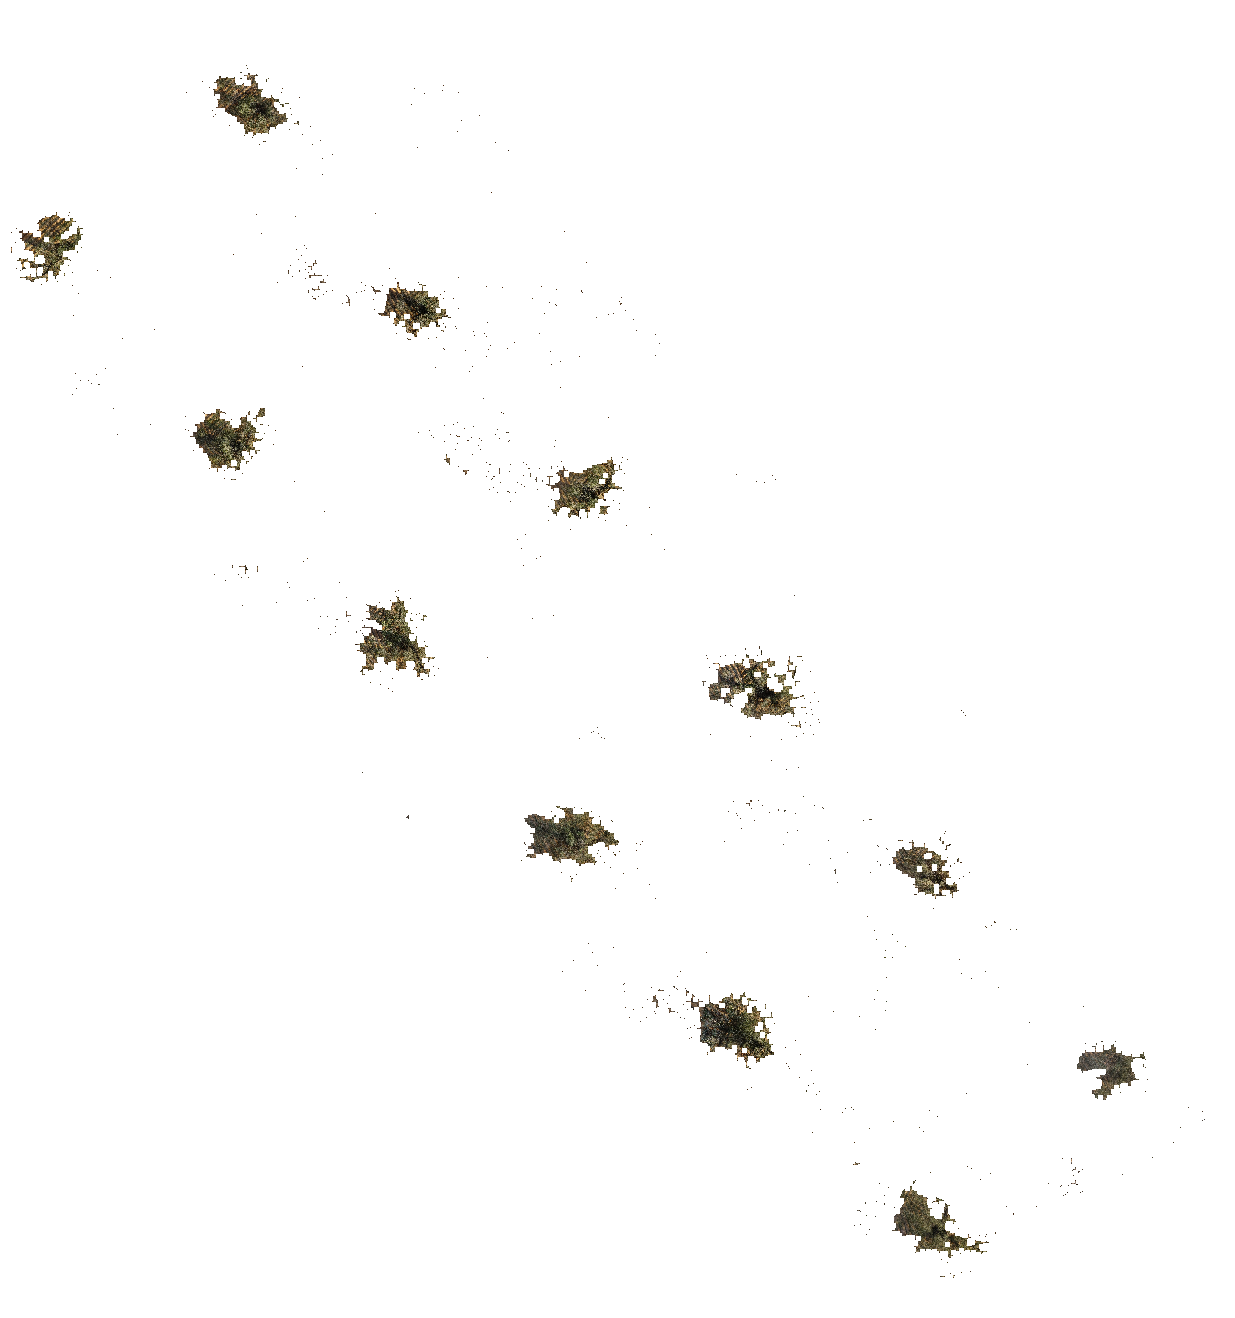

True

In [2]:
# Load the image
image_path = '/content/image_projet.png'
image = cv2.imread(image_path)

# Convert image to the HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define lower and upper bounds for the color of the olive trees (HSV values)
lower_olive = np.array([13, 0, 0])
upper_olive = np.array([80, 255, 80])

# Create a mask for the olive trees
olive_mask = cv2.inRange(hsv_image, lower_olive, upper_olive)

# Apply morphological operations to improve the mask
kernel = np.ones((5, 5), np.uint8)
olive_mask = cv2.morphologyEx(olive_mask, cv2.MORPH_CLOSE, kernel)

# Invert the mask to get the background mask
background_mask = cv2.bitwise_not(olive_mask)

# Create a white background
white_background = np.ones_like(image) * 255

# Set the olive trees on the white background
segmented_olives = cv2.bitwise_and(image, image, mask=olive_mask)
segmented_background = cv2.bitwise_and(white_background, white_background, mask=background_mask)
result = cv2.add(segmented_olives, segmented_background)

# Display the segmented olive trees on a white background
cv2_imshow(result)
cv2.imwrite("photo_segmented.png", result)

In [3]:
# Load the image
image_path = '/content/download.png'
image = cv2.imread(image_path)

# Convert image to the HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define lower and upper bounds for the color of the soil (HSV values)
lower_green = np.array([13, 0, 0])
upper_green = np.array([80, 255, 80])  # Adjust the upper bound for soil color

# Create a mask for the soil
green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Apply morphological operations to improve the mask
kernel = np.ones((5, 5), np.uint8)
green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)


# Find contours in the soil mask
contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate total image area
total_image_area = image.shape[0] * image.shape[1]

# Initialize lists to store percentages
green_percentages = []
soil_percentages = []
white_percentages = []
black_percentages = []
lai_percentages = []

# Loop through each object's contour
for contour in contours:
    area = cv2.contourArea(contour)

    if area > 30 * 30:  # Minimum object size criterion
        # Create masks for the current object
        object_mask = np.zeros_like(green_mask)
        cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

        olive_pixels = cv2.bitwise_and(image, image, mask=object_mask)

        # Calculate pixel counts for each category
        soil_pixel_count = np.sum(np.all((olive_pixels >=[0, 50, 50]) & (olive_pixels <= [30, 255, 255]), axis=-1))
        green_pixel_count = np.sum(np.all((olive_pixels>=50) & (olive_pixels<=100) , axis=-1))
        white_pixel_count = np.sum(np.all(olive_pixels == [255, 255, 255], axis=-1))
        black_pixel_count = np.sum(np.all(olive_pixels< [0, 0, 0], axis=-1))

        total_pixels = green_pixel_count + soil_pixel_count + white_pixel_count + black_pixel_count

        # # Calculate green and soil areas for the current object
        # green_area = np.sum(cv2.bitwise_and(object_mask, olive_mask))
        # soil_area = np.sum(cv2.bitwise_and(object_mask, soil_mask))

        # Calculate percentages for the current object
        green_percentage = (green_pixel_count /total_pixels ) * 100
        white_percentage = (white_pixel_count / total_pixels ) * 100
        soil_percentage = ((soil_pixel_count / total_pixels ) *100) + (white_percentage/2)
        lai_percentage = (- 2 * math.log(1 - (soil_percentage/100)))*100

        black_percentage = (black_pixel_count / total_pixels ) * 100

        # Append percentages to lists
        green_percentages.append(green_percentage)
        soil_percentages.append(soil_percentage)
        lai_percentages.append(lai_percentage)
        white_percentages.append(white_percentage)
        black_percentages.append(black_percentage)

# Display the results
print("Green Percentages:",np.mean(green_percentages))
print("Soil Percentages:", np.mean(soil_percentages))
print("lai Percentages:", np.mean(lai_percentages))
print("white Percentages:",np.mean( white_percentages))

Green Percentages: 70.1043306395383
Soil Percentages: 24.79973714434438
lai Percentages: 59.41302364986746
white Percentages: 10.19186443223463


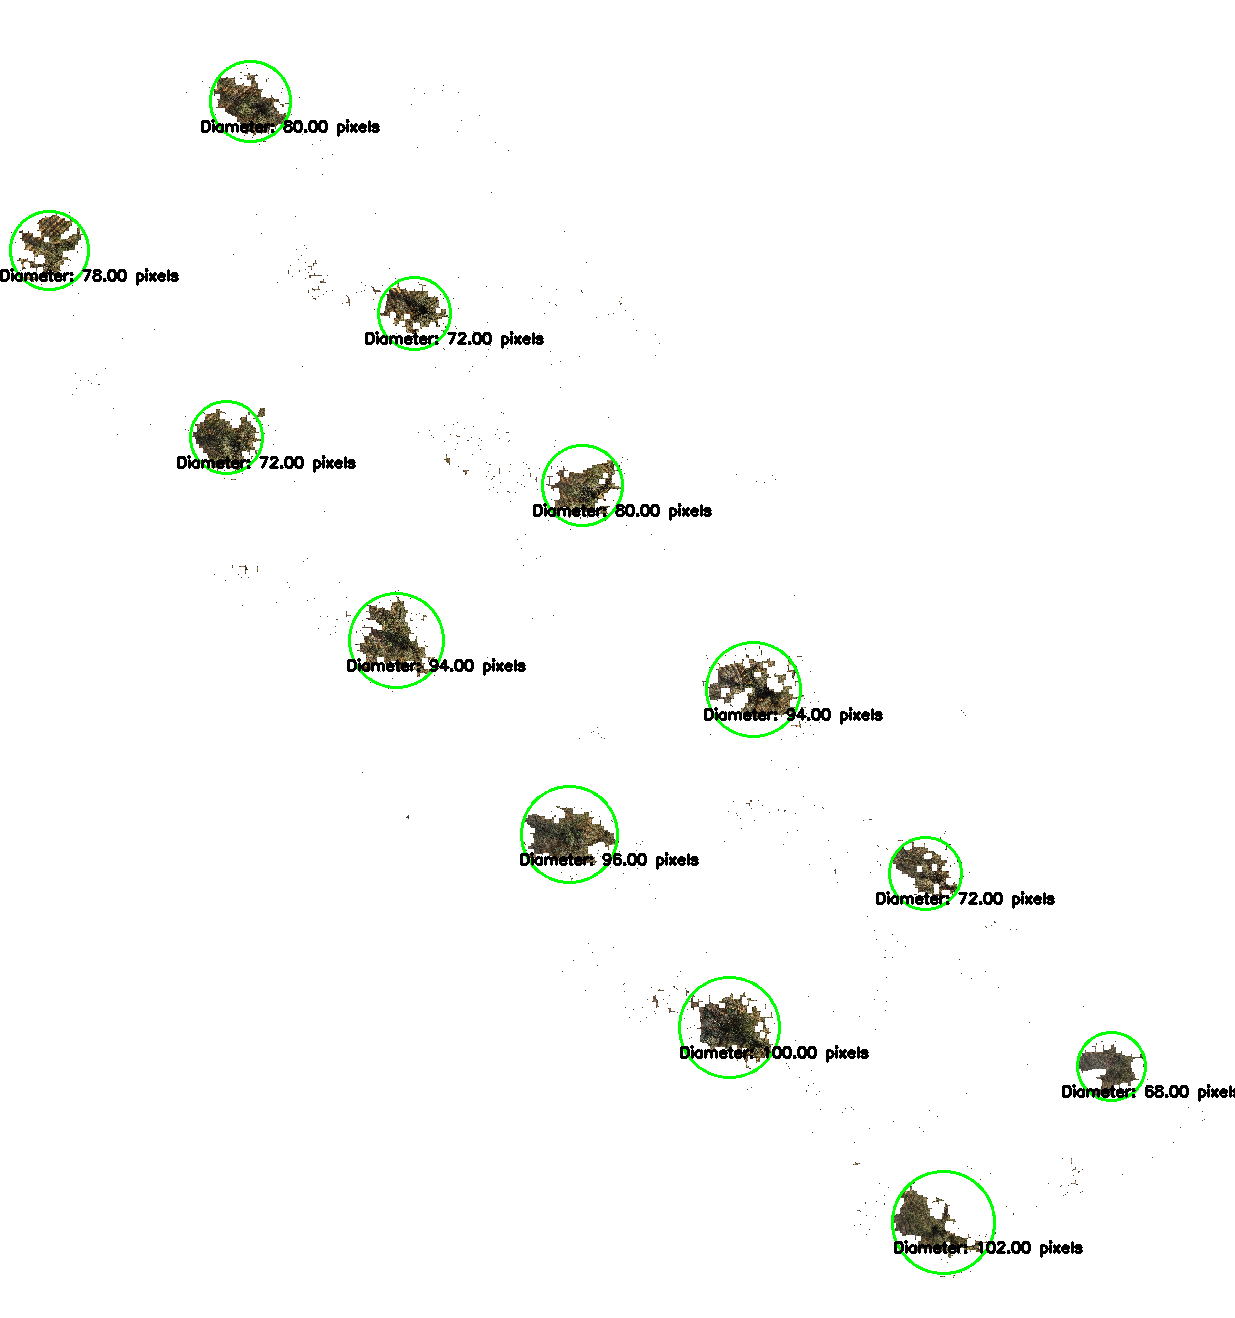

Diameters: [102, 68, 100, 72, 96, 94, 94, 80, 72, 72, 78, 80]


In [4]:
# Load the image
image_path = '/content/download.png'
image = cv2.imread(image_path)

# Convert image to the HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define lower and upper bounds for the color of the olive trees (HSV values)
lower_olive = np.array([13, 0, 0])
upper_olive = np.array([80, 255, 80])

# Create a mask for the olive trees
olive_mask = cv2.inRange(hsv_image, lower_olive, upper_olive)

# Apply morphological operations to improve the mask
kernel = np.ones((5, 5), np.uint8)
olive_mask = cv2.morphologyEx(olive_mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the olive_mask
contours, _ = cv2.findContours(olive_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty list to store diameter values
diameters = []

# Iterate through the detected contours
for contour in contours:
    # Calculate the center (x, y) and radius of the enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(contour)
    radius = int(radius)

    # Only process objects with a diameter less than 30 pixels
    if radius > 15:
        # Append the diameter value to the list
        diameters.append(2 * radius)

        # Draw the circle on the original image
        cv2.circle(image, (int(x), int(y)), radius, (0, 255, 0), 2)  # You can change the color and thickness as desired

        # Write the diameter value next to the circle
        diameter_text = f"Diameter: {2 * radius:.2f} pixels"  # Calculate diameter from radius
        cv2.putText(image, diameter_text, (int(x) - 50, int(y) + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

# Display the image with circles and diameter values
cv2_imshow(image)

# Save the resulting image
cv2.imwrite("photo_with_diameters.png", image)

# Print the list of diameters
print("Diameters:", diameters)


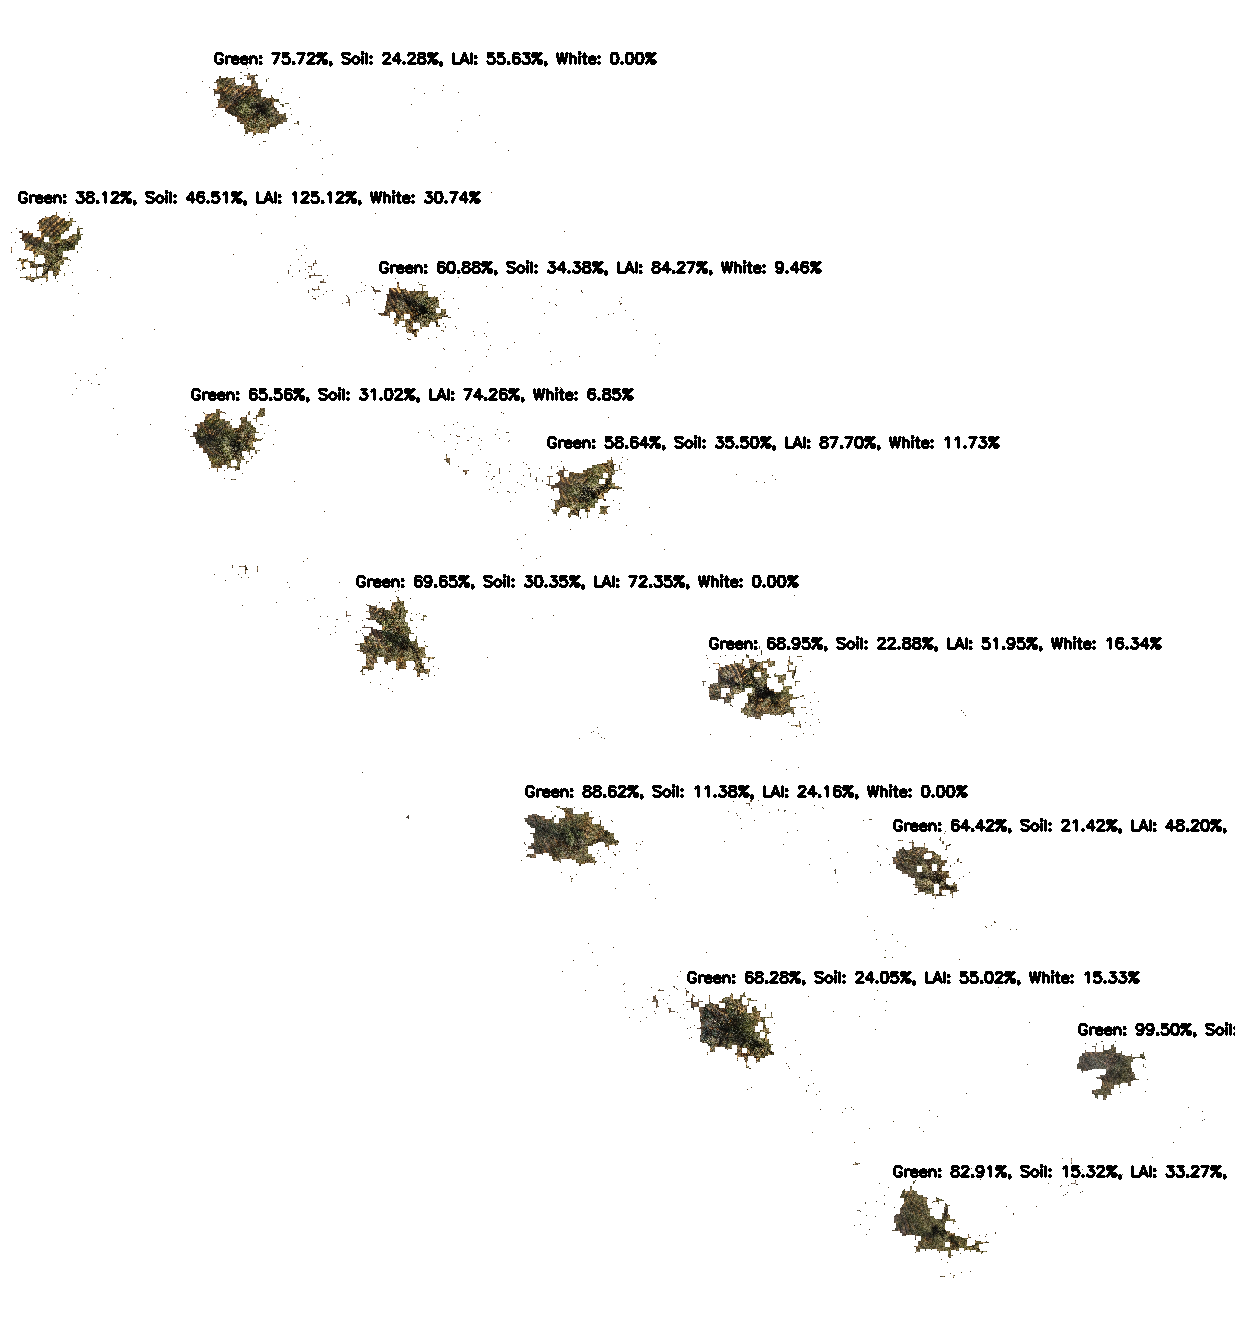

Mean Green Percentage: 70.10416666666667
Mean Soil Percentage: 24.799166666666668
Mean LAI Percentage: 59.41166666666667
Mean White Percentage: 10.191666666666666


In [5]:
# Load the image
image_path = '/content/download.png'
image = cv2.imread(image_path)

# Convert image to the HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define lower and upper bounds for the color of the soil (HSV values)
lower_green = np.array([13, 0, 0])
upper_green = np.array([80, 255, 80])  # Adjust the upper bound for soil color

# Create a mask for the soil
green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Apply morphological operations to improve the mask
kernel = np.ones((5, 5), np.uint8)
green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the soil mask
contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate total image area
total_image_area = image.shape[0] * image.shape[1]

# Initialize lists to store percentages
green_percentages = []
soil_percentages = []
white_percentages = []
black_percentages = []
lai_percentages = []

# Loop through each object's contour
for contour in contours:
    area = cv2.contourArea(contour)

    if area > 30 * 30:  # Minimum object size criterion
        # Create masks for the current object
        object_mask = np.zeros_like(green_mask)
        cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

        olive_pixels = cv2.bitwise_and(image, image, mask=object_mask)

        # Calculate pixel counts for each category
        soil_pixel_count = np.sum(np.all((olive_pixels >= [0, 50, 50]) & (olive_pixels <= [30, 255, 255]), axis=-1))
        green_pixel_count = np.sum(np.all((olive_pixels >= 50) & (olive_pixels <= 100), axis=-1))
        white_pixel_count = np.sum(np.all(olive_pixels == [255, 255, 255], axis=-1))
        black_pixel_count = np.sum(np.all(olive_pixels < [0, 0, 0], axis=-1))

        total_pixels = green_pixel_count + soil_pixel_count + white_pixel_count + black_pixel_count

        # Calculate percentages for the current object
        green_percentage = (green_pixel_count / total_pixels) * 100
        white_percentage = (white_pixel_count / total_pixels) * 100
        soil_percentage = ((soil_pixel_count / total_pixels) * 100) + (white_percentage / 2)
        lai_percentage = (-2 * math.log(1 - (soil_percentage / 100))) * 100
        black_percentage = (black_pixel_count / total_pixels) * 100

        # Append percentages to lists
        green_percentages.append(float(f"{green_percentage:.2f}"))
        soil_percentages.append(float(f"{soil_percentage:.2f}"))
        lai_percentages.append(float(f"{lai_percentage:.2f}"))
        white_percentages.append(float(f"{white_percentage:.2f}"))
        black_percentages.append(float(f"{black_percentage:.2f}"))

        # Draw text on the image
        x, y, _, _ = cv2.boundingRect(contour)
        text = f"Green: {green_percentage:.2f}%, Soil: {soil_percentage:.2f}%, LAI: {lai_percentage:.2f}%, White: {white_percentage:.2f}%"
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

# Display the image with text
cv2_imshow(image)

# Save the resulting image
cv2.imwrite("photo_with_percentages.png", image)

# Print the mean values of the percentages
print("Mean Green Percentage:", np.mean(green_percentages))
print("Mean Soil Percentage:", np.mean(soil_percentages))
print("Mean LAI Percentage:", np.mean(lai_percentages))
print("Mean White Percentage:", np.mean(white_percentages))


In [6]:
olive_amount=[73.34,46.67,73.33,46.66,73.34,46.66,43.33,60,43.34,60,43.33,60]

In [7]:
data=pd.DataFrame({"Green Percentage":green_percentages," Soil Percentage":soil_percentages," LAI Percentage":lai_percentages,"White Percentage":white_percentages,"diameter":diameters,"olive_amount":olive_amount})


In [8]:
data

,Green Percentage,Soil Percentage,LAI Percentage,White Percentage,diameter,olive_amount
0,82.91,15.32,33.27,3.53,102,73.34
1,99.50,0.50,1.01,0.00,68,46.67
2,68.28,24.05,55.02,15.33,100,73.33
3,64.42,21.42,48.20,28.32,72,46.66
4,88.62,11.38,24.16,0.00,96,73.34
5,68.95,22.88,51.95,16.34,94,46.66
6,69.65,30.35,72.35,0.00,94,43.33
7,58.64,35.50,87.70,11.73,80,60.00
8,65.56,31.02,74.26,6.85,72,43.34
9,60.88,34.38,84.27,9.46,72,60.00


In [9]:
data.describe()

,Green Percentage,Soil Percentage,LAI Percentage,White Percentage,diameter,olive_amount
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,70.104167,24.799167,59.411667,10.191667,84.000000,55.833333
std,15.666416,12.148632,32.579151,10.825062,12.358288,12.403080
min,38.120000,0.500000,1.010000,0.000000,68.000000,43.330000
25%,63.535000,19.895000,44.467500,0.000000,72.000000,45.830000
50%,68.615000,24.165000,55.325000,8.155000,80.000000,53.335000
75%,77.517500,31.860000,76.762500,15.582500,94.500000,63.332500
max,99.500000,46.510000,125.120000,30.740000,102.000000,73.340000


In [10]:
data.dtypes

Green Percentage    float64
 Soil Percentage    float64
 LAI Percentage     float64
White Percentage    float64
diameter              int64
olive_amount        float64
dtype: object

In [11]:
column_names = data.columns
for column in column_names:
    print(column + ' - ' + str(data[column].isnull().sum()))

Green Percentage - 0
 Soil Percentage - 0
 LAI Percentage - 0
White Percentage - 0
diameter - 0
olive_amount - 0


Text(0, 0.5, 'olive_amount Probability')

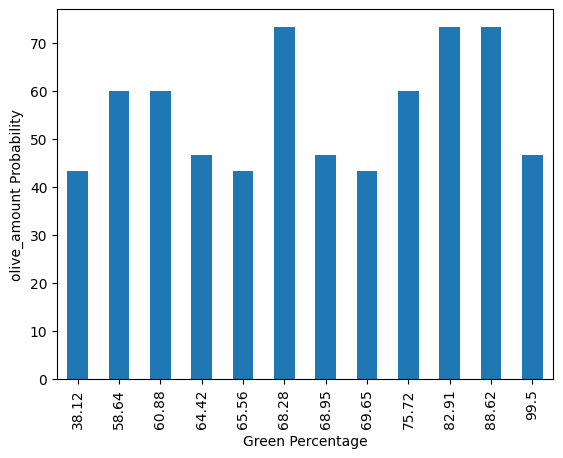

In [12]:
plt = data[['Green Percentage', 'olive_amount']].groupby('Green Percentage').mean().olive_amount.plot(kind='bar')
plt.set_xlabel('Green Percentage')
plt.set_ylabel('olive_amount Probability')

Text(0, 0.5, 'olive_amount Probability')

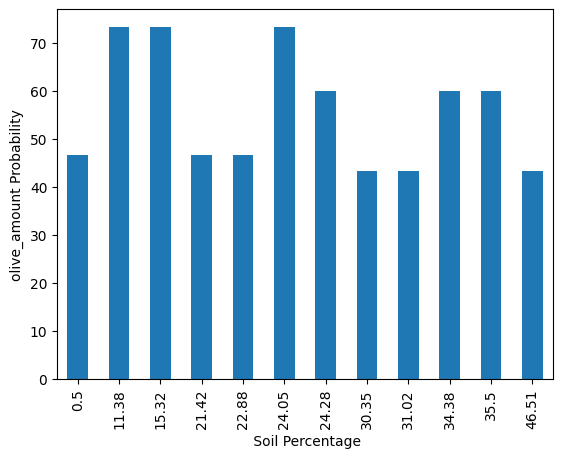

In [13]:
plt = data[[' Soil Percentage', 'olive_amount']].groupby(' Soil Percentage').mean().olive_amount.plot(kind='bar')
plt.set_xlabel(' Soil Percentage')
plt.set_ylabel('olive_amount Probability')

Text(0, 0.5, 'olive_amount Probability')

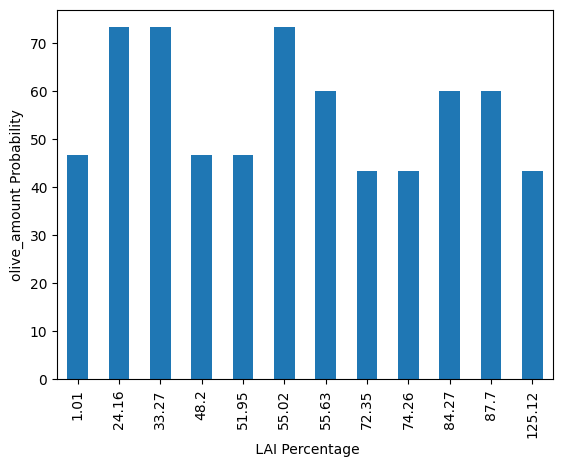

In [14]:
plt = data[[' LAI Percentage', 'olive_amount']].groupby(' LAI Percentage').mean().olive_amount.plot(kind='bar')
plt.set_xlabel(' LAI Percentage')
plt.set_ylabel('olive_amount Probability')

Text(0, 0.5, 'olive_amount Probability')

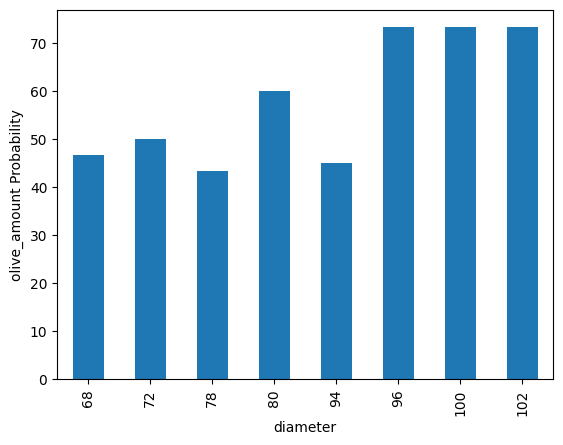

In [15]:
plt = data[['diameter', 'olive_amount']].groupby('diameter').mean().olive_amount.plot(kind='bar')
plt.set_xlabel('diameter')
plt.set_ylabel('olive_amount Probability')

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = data.drop(columns=['olive_amount'])  # Features
y = data['olive_amount']  # Target

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9, 5)
X_test shape: (3, 5)
y_train shape: (9,)
y_test shape: (3,)


In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
LR=LinearRegression()
LR.fit(X_train,y_train)

LinearRegression()

In [20]:
Pred =LR.predict(X_test)

In [21]:
y_pred=Pred.round()

#Mean Absolute Error
    Mean Absolute Error (MAE) is a metric used to measure the average magnitude of errors between predicted and actual values in a regression problem
#r2 score
    The r2 score, also known as the coefficient of determination, is a statistical measure used to assess the goodness of fit of a regression model.
#explained variance score
    The explained variance score is a metric used to evaluate the performance of a regression model.
#max error
    The max_error is a metric used to evaluate the worst-case error or the maximum deviation between the predicted values and the true values in a regression problem.
#Mean Squared Error
    Mean Squared Error (MSE) is a metric used to evaluate the performance of a regression model. It measures the average of the squared differences between the predicted and actual values.

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error

In [23]:
explained_variance = explained_variance_score(y_test,  y_pred)
print(f"Explained Variance Score:{explained_variance:.2f}") #A higher(closer to 1) explained variance score indicates a better fit of the model to the data.

r2 = r2_score(y_test, y_pred)
print(f"R-2 score: {r2:.2f}")#An r2 score closer to 1 indicates a better fit of the model to the data

max_err = max_error(y_test, y_pred)
print(f"Maximum Error:{max_err:.2f}")

mae = mean_absolute_error(y_test,  y_pred)
print(f"Mean Absolute Error (MAE):{mae:.2f}")

mse = mean_squared_error(y_test,  y_pred)
# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE):{mse:.2}")
print(f"Root Mean Squared Error (RMSE):{rmse:.2f}")

Explained Variance Score:0.55
R-2 score: 0.54
Maximum Error:10.67
Mean Absolute Error (MAE):8.00
Mean Squared Error (MSE):6.9e+01
Root Mean Squared Error (RMSE):8.29


In [24]:
from sklearn.tree import DecisionTreeRegressor

In [25]:
# Initialize the DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor()

In [26]:
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [27]:
# Predict on the test data
y_pred = tree_regressor.predict(X_test)

In [28]:
explained_variance = explained_variance_score(y_test,  y_pred)
print(f"Explained Variance Score:{explained_variance:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R-2 score: {r2:.2f}")

max_err = max_error(y_test, y_pred)
print(f"Maximum Error:{max_err:.2f}")

mae = mean_absolute_error(y_test,  y_pred)
print(f"Mean Absolute Error (MAE):{mae:.2f}")

mse = mean_squared_error(y_test,  y_pred)
# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE):{mse:.2}")
print(f"Root Mean Squared Error (RMSE):{rmse:.2f}")

Explained Variance Score:0.59
R-2 score: 0.39
Maximum Error:16.67
Mean Absolute Error (MAE):5.56
Mean Squared Error (MSE):9.3e+01
Root Mean Squared Error (RMSE):9.62


In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
# Create a Random Forest Regressor model with desired parameters
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust 'n_estimators' and other hyperparameters

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
# Predict on the test data
y_pred = rf_model.predict(X_test)

In [32]:
explained_variance = explained_variance_score(y_test,  y_pred)
print(f"Explained Variance Score:{explained_variance:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R-2 score: {r2:.2f}")

max_err = max_error(y_test, y_pred)
print(f"Maximum Error:{max_err:.2f}")

mae = mean_absolute_error(y_test,  y_pred)
print(f"Mean Absolute Error (MAE):{mae:.2f}")

mse = mean_squared_error(y_test,  y_pred)
# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE):{mse:.2}")
print(f"Root Mean Squared Error (RMSE):{rmse:.2f}")

Explained Variance Score:0.52
R-2 score: 0.52
Maximum Error:12.47
Mean Absolute Error (MAE):7.76
Mean Squared Error (MSE):7.2e+01
Root Mean Squared Error (RMSE):8.50


In [33]:
import xgboost as xgb

In [34]:
# Create an XGBoost linear regression model with desired parameters
xgb_model = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror')  # Use the 'gblinear' booster

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
# Predict on the test data
y_pred = xgb_model.predict(X_test)

In [36]:
explained_variance = explained_variance_score(y_test,  y_pred)
print(f"Explained Variance Score:{explained_variance:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R-2 score: {r2:.2f}")

max_err = max_error(y_test, y_pred)
print(f"Maximum Error:{max_err:.2f}")

mae = mean_absolute_error(y_test,  y_pred)
print(f"Mean Absolute Error (MAE):{mae:.2f}")

mse = mean_squared_error(y_test,  y_pred)
# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE):{mse:.2}")
print(f"Root Mean Squared Error (RMSE):{rmse:.2f}")

Explained Variance Score:0.72
R-2 score: 0.44
Maximum Error:11.96
Mean Absolute Error (MAE):8.29
Mean Squared Error (MSE):8.5e+01
Root Mean Squared Error (RMSE):9.21
